In [16]:
import pandas
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import MyCode.utils as utils
import graphviz
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
import ast

In [17]:
pd.set_option('max_columns', None)
FILE_NAME = "HR"

# src: https://www.kaggle.com/hjmjerry/gender-discrimination
df = pandas.read_csv("dataset_perso/HRDataset_v14.csv")
del df['Employee_Name']
del df['EmpID']
df

,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,Termd,PositionID,Position,State,Zip,DOB,Sex,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,DateofHire,DateofTermination,TermReason,EmploymentStatus,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences
0,0,0,1,1,5,4,0,62506,0,19,Production Technician I,MA,1960,07/10/83,M,Single,US Citizen,No,White,7/5/2011,NaN,N/A-StillEmployed,Active,Production,Michael Albert,22.0,LinkedIn,Exceeds,4.60,5,0,1/17/2019,0,1
1,1,1,1,5,3,3,0,104437,1,27,Sr. DBA,MA,2148,05/05/75,M,Married,US Citizen,No,White,3/30/2015,6/16/2016,career change,Voluntarily Terminated,IT/IS,Simon Roup,4.0,Indeed,Fully Meets,4.96,3,6,2/24/2016,0,17
2,1,1,0,5,5,3,0,64955,1,20,Production Technician II,MA,1810,09/19/88,F,Married,US Citizen,No,White,7/5/2011,9/24/2012,hours,Voluntarily Terminated,Production,Kissy Sullivan,20.0,LinkedIn,Fully Meets,3.02,3,0,5/15/2012,0,3
3,1,1,0,1,5,3,0,64991,0,19,Production Technician I,MA,1886,09/27/88,F,Married,US Citizen,No,White,1/7/2008,NaN,N/A-StillEmployed,Active,Production,Elijiah Gray,16.0,Indeed,Fully Meets,4.84,5,0,1/3/2019,0,15
4,0,2,0,5,5,3,0,50825,1,19,Production Technician I,MA,2169,09/08/89,F,Divorced,US Citizen,No,White,7/11/2011,9/6/2016,return to school,Voluntarily Terminated,Production,Webster Butler,39.0,Google Search,Fully Meets,5.00,4,0,2/1/2016,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,0,0,1,1,5,3,0,65893,0,20,Production Technician II,MA,1810,05/11/85,M,Single,US Citizen,No,White,7/7/2014,NaN,N/A-StillEmployed,Active,Production,Kissy Sullivan,20.0,LinkedIn,Fully Meets,4.07,4,0,2/28/2019,0,13
307,0,0,0,5,5,1,0,48513,1,19,Production Technician I,MA,2458,05/04/82,F,Single,US Citizen,No,Asian,9/2/2008,9/29/2015,Another position,Voluntarily Terminated,Production,Brannon Miller,12.0,Google Search,PIP,3.20,2,0,9/2/2015,5,4
308,0,0,0,1,3,4,0,220450,0,6,CIO,MA,2067,08/30/79,F,Single,US Citizen,No,White,4/10/2010,NaN,N/A-StillEmployed,Active,IT/IS,Janet King,2.0,Employee Referral,Exceeds,4.60,5,6,2/21/2019,0,16
309,0,0,0,1,3,3,0,89292,0,9,Data Analyst,MA,2148,02/24/79,F,Single,US Citizen,No,White,3/30/2015,NaN,N/A-StillEmployed,Active,IT/IS,Simon Roup,4.0,Employee Referral,Fully Meets,5.00,3,5,2/1/2019,0,11


In [18]:
salary_mean = np.mean(np.array(df["Salary"].tolist(), float))
print(f"Mean: {salary_mean}")
for i in range(0,len(df)):
    if df.at[i, "Salary"] >= salary_mean:
        df.at[i, "Salary_mean"] = 1
    else:
        df.at[i, "Salary_mean"] = 0
del df["Salary"]

for i in range(0,len(df)):
    df.at[i, "Absences"] = df.at[i, "Absences"] / 5
for i in range(0,len(df)):
    df.at[i, "EngagementSurvey"] = int(df.at[i, "EngagementSurvey"])
for i in range(0,len(df)):
    if df.at[i, "HispanicLatino"] == 'Yes' or df.at[i, "HispanicLatino"] == 'yes' :
        df.at[i, "HispanicLatino"] = 1
    elif df.at[i, "HispanicLatino"] == 'No' or df.at[i, "HispanicLatino"] == 'no' :
        df.at[i, "HispanicLatino"] = 0

df

Mean: 69020.6848874598


,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Termd,PositionID,Position,State,Zip,DOB,Sex,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,DateofHire,DateofTermination,TermReason,EmploymentStatus,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences,Salary_mean
0,0,0,1,1,5,4,0,0,19,Production Technician I,MA,1960,07/10/83,M,Single,US Citizen,0,White,7/5/2011,NaN,N/A-StillEmployed,Active,Production,Michael Albert,22.0,LinkedIn,Exceeds,4.0,5,0,1/17/2019,0,0,0.0
1,1,1,1,5,3,3,0,1,27,Sr. DBA,MA,2148,05/05/75,M,Married,US Citizen,0,White,3/30/2015,6/16/2016,career change,Voluntarily Terminated,IT/IS,Simon Roup,4.0,Indeed,Fully Meets,4.0,3,6,2/24/2016,0,3,1.0
2,1,1,0,5,5,3,0,1,20,Production Technician II,MA,1810,09/19/88,F,Married,US Citizen,0,White,7/5/2011,9/24/2012,hours,Voluntarily Terminated,Production,Kissy Sullivan,20.0,LinkedIn,Fully Meets,3.0,3,0,5/15/2012,0,0,0.0
3,1,1,0,1,5,3,0,0,19,Production Technician I,MA,1886,09/27/88,F,Married,US Citizen,0,White,1/7/2008,NaN,N/A-StillEmployed,Active,Production,Elijiah Gray,16.0,Indeed,Fully Meets,4.0,5,0,1/3/2019,0,3,0.0
4,0,2,0,5,5,3,0,1,19,Production Technician I,MA,2169,09/08/89,F,Divorced,US Citizen,0,White,7/11/2011,9/6/2016,return to school,Voluntarily Terminated,Production,Webster Butler,39.0,Google Search,Fully Meets,5.0,4,0,2/1/2016,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,0,0,1,1,5,3,0,0,20,Production Technician II,MA,1810,05/11/85,M,Single,US Citizen,0,White,7/7/2014,NaN,N/A-StillEmployed,Active,Production,Kissy Sullivan,20.0,LinkedIn,Fully Meets,4.0,4,0,2/28/2019,0,2,0.0
307,0,0,0,5,5,1,0,1,19,Production Technician I,MA,2458,05/04/82,F,Single,US Citizen,0,Asian,9/2/2008,9/29/2015,Another position,Voluntarily Terminated,Production,Brannon Miller,12.0,Google Search,PIP,3.0,2,0,9/2/2015,5,0,0.0
308,0,0,0,1,3,4,0,0,6,CIO,MA,2067,08/30/79,F,Single,US Citizen,0,White,4/10/2010,NaN,N/A-StillEmployed,Active,IT/IS,Janet King,2.0,Employee Referral,Exceeds,4.0,5,6,2/21/2019,0,3,1.0
309,0,0,0,1,3,3,0,0,9,Data Analyst,MA,2148,02/24/79,F,Single,US Citizen,0,White,3/30/2015,NaN,N/A-StillEmployed,Active,IT/IS,Simon Roup,4.0,Employee Referral,Fully Meets,5.0,3,5,2/1/2019,0,2,1.0


In [19]:
col = ['EmpStatusID', 'PerfScoreID', 'Position', 'MaritalDesc', 'CitizenDesc', 'RaceDesc', 'Department', 'PerformanceScore', 'EmpSatisfaction', 'Absences']
df = df.drop(['MarriedID', 'MaritalStatusID', 'Zip', 'DOB', 'Sex', 'DateofHire','DateofTermination', 'TermReason', 'EmploymentStatus', 'ManagerName', 'ManagerID', 'EngagementSurvey', 'LastPerformanceReview_Date', 'DaysLateLast30', 'RecruitmentSource', 'State', 'DeptID', 'PositionID', 'SpecialProjectsCount'], axis=1)
df = pd.get_dummies(df, columns=col)
for col in df:
    if len(df[col].unique()) > 2:
        print(f'{col}: {df[col].unique()}')
df

,GenderID,FromDiversityJobFairID,Termd,HispanicLatino,Salary_mean,EmpStatusID_1,EmpStatusID_2,EmpStatusID_3,EmpStatusID_4,EmpStatusID_5,PerfScoreID_1,PerfScoreID_2,PerfScoreID_3,PerfScoreID_4,Position_Accountant I,Position_Administrative Assistant,Position_Area Sales Manager,Position_BI Developer,Position_BI Director,Position_CIO,Position_Data Analyst,Position_Data Analyst,Position_Data Architect,Position_Database Administrator,Position_Director of Operations,Position_Director of Sales,Position_Enterprise Architect,Position_IT Director,Position_IT Manager - DB,Position_IT Manager - Infra,Position_IT Manager - Support,Position_IT Support,Position_Network Engineer,Position_President & CEO,Position_Principal Data Architect,Position_Production Manager,Position_Production Technician I,Position_Production Technician II,Position_Sales Manager,Position_Senior BI Developer,Position_Shared Services Manager,Position_Software Engineer,Position_Software Engineering Manager,Position_Sr. Accountant,Position_Sr. DBA,Position_Sr. Network Engineer,MaritalDesc_Divorced,MaritalDesc_Married,MaritalDesc_Separated,MaritalDesc_Single,MaritalDesc_Widowed,CitizenDesc_Eligible NonCitizen,CitizenDesc_Non-Citizen,CitizenDesc_US Citizen,RaceDesc_American Indian or Alaska Native,RaceDesc_Asian,RaceDesc_Black or African American,RaceDesc_Hispanic,RaceDesc_Two or more races,RaceDesc_White,Department_Admin Offices,Department_Executive Office,Department_IT/IS,Department_Production,Department_Sales,Department_Software Engineering,PerformanceScore_Exceeds,PerformanceScore_Fully Meets,PerformanceScore_Needs Improvement,PerformanceScore_PIP,EmpSatisfaction_1,EmpSatisfaction_2,EmpSatisfaction_3,EmpSatisfaction_4,EmpSatisfaction_5,Absences_0,Absences_1,Absences_2,Absences_3,Absences_4
0,1,0,0,0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0
1,1,0,1,0,1.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
2,0,0,1,0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
3,0,0,0,0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0,1,0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,1,0,0,0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
307,0,0,1,0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
308,0,0,0,0,1.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
309,0,0,0,0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0


In [20]:
X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]
y = df['Salary_mean']
sensitive = df['GenderID']
print(utils.discrimination(y, sensitive))

-0.11691919191919192


In [21]:
for i in range(0,len(df)):
    if df.at[i, "GenderID"] == 1:
        df.at[i, "GenderID"] = 0
    else:
        df.at[i, "GenderID"] = 1

In [22]:
X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]
y = df['Salary_mean']
sensitive = df['GenderID']
print(utils.discrimination(y, sensitive))

0.11691919191919192


In [6]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

NameError: name 'sensitive' is not defined

In [7]:


from tqdm import tqdm
from multiprocessing import Process, Pool
from functools import partial

result = pd.DataFrame(columns=["k", "depth", "random_state", "clf.error_", "clf.accuracy_", "accuracy_pred", "accuracy_test", "sum_misclassified_train", "discrimination_train", "discrimination_train_pred", "discrimination_test", "sum_discrimination_additive_train", "sum_discrimination_additive_train_pred", "sum_discrimination_additive_test_pred", "sum_discrimination_additive_train_abs", "sum_discrimination_additive_train_pred_abs", "sum_discrimination_additive_test_pred_abs", "duration", "min_supp", "clf.tree_"])

def xx(min_supp, random_state, X_train, X_test, y_train, y_test, sensitive_train, sensitive_test, depth, k):

    clf = DL85Classifier(max_depth=depth, error_function=lambda tids: utils.error(list(tids), k, y_train, sensitive_train), min_sup=min_supp, time_limit=300)

    start = time.perf_counter()
    clf.fit(X_train, list(y_train))
    duration = time.perf_counter() - start
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    accuracy_pred = round(accuracy_score(y_train, y_pred_train), 8)
    accuracy_test = round(accuracy_score(y_test, y_pred_test), 8)
    discrimination_train = round(utils.discrimination(y_train, sensitive_train), 8)
    discrimination_train_pred = round(utils.discrimination(y_pred_train, sensitive_train), 8)
    discrimination_test = round(utils.discrimination(y_pred_test, sensitive_test), 8)

    utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
    sum_discrimination_additive_train_pred = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=False),8)
    sum_discrimination_additive_train_pred_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=True),8)

    sum_discrimination_additive_train = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False),8)
    sum_discrimination_additive_train_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True),8)
    sum_misclassified_train = round(utils.sum_elem_tree(clf.tree_, 'misclassified'),8)

    discri_test= list()
    utils.get_discri_test(clf.tree_, X_test, y_test, sensitive_test, discri_test, X.columns, path=None)
    sum_discrimination_additive_test_pred = sum(discri_test)
    sum_discrimination_additive_test_pred_abs = 0
    [sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]
    #print(f"### Depth: {depth} state: {random_state} k:{k} ###")

    return [k, depth, random_state, clf.error_, clf.accuracy_, accuracy_pred, accuracy_test, sum_misclassified_train, discrimination_train, discrimination_train_pred, discrimination_test, sum_discrimination_additive_train, sum_discrimination_additive_train_pred, sum_discrimination_additive_test_pred, sum_discrimination_additive_train_abs, sum_discrimination_additive_train_pred_abs, sum_discrimination_additive_test_pred_abs, duration, min_supp, clf.tree_]

pool = Pool()
if True:
    min_supp = 2
    args = []
    for depth in [ 3, 5, 7]:
        for k in [0, 1, 5, 10, 50, 100, 250, 500, 1000, 5000, 100000]:
            args.append((depth, k))
    for random_state in tqdm(range(1, 101, 4)):
        if random_state in [17, 35, 43, 65, 71, 91]:
                continue
        X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)
        try:
            for res in pool.starmap(partial(xx, min_supp, random_state, X_train, X_test, y_train, y_test, sensitive_train, sensitive_test), args):
                result.loc[len(result.index)] = res
        except:
            print("An error occured" +str(random_state))
    result = result.sort_values(['k', 'depth', 'min_supp'])
    result.to_csv('save/'+FILE_NAME+'.csv', index=False)

  0%|          | 0/25 [00:00<?, ?it/s]


NameError: name 'sensitive' is not defined

In [ ]:
result = pd.read_csv('save/'+FILE_NAME+".csv")
result

In [8]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.error(list(tids), 10, y_train, sensitive_train), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(f'accuracy_pred = {round(accuracy_score(y_train, y_pred_train), 8)}')
print(f'accuracy_test = {round(accuracy_score(y_test, y_pred_test), 8)}')
print(f'discrimination_train = {round(utils.discrimination(y_train, sensitive_train), 8)}')
print(f'discrimination_train_pred = {round(utils.discrimination(y_pred_train, sensitive_train), 8)}')

utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
dot = utils.export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/"+FILE_NAME+"tree")
graphviz.Source(dot)


NameError: name 'sensitive' is not defined

In [ ]:
discri_test= list()
utils.get_discri_test(clf.tree_, X_test, y_test, sensitive_test, discri_test, X.columns, path=None)
sum_discrimination_additive_test_pred = sum(discri_test)
sum_discrimination_additive_test_pred_abs = 0
[sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]
print(sum_discrimination_additive_test_pred)
sum_discrimination_additive_test_pred_abs

In [ ]:
discri_test

In [ ]:
utils.discrimination(y_train, sensitive_train)

In [ ]:
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_train'))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_train', do_abs=True))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_pred'))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_pred', do_abs=True))

In [ ]:
utils.sum_elem_tree(clf.tree_, 'misclassified')

In [ ]:
print(utils.discrimination(y_train, sensitive_train))
print(utils.discrimination(y_pred_train, sensitive_train))
print(utils.discrimination(y_test, sensitive_test))
print(utils.discrimination(y_pred_test, sensitive_test))

In [ ]:
clf.tree_

# Graphs

In [ ]:
utils.plot_mean("depth", "discrimination_train_pred", result, 0.15, 0.6)

In [ ]:
utils.plot_mean("depth", "discrimination_test", result, 0, 0.4)

In [ ]:
utils.plot_mean("depth", "clf.accuracy_", result, 0, 2)

In [ ]:
utils.plot_mean("depth", "accuracy_pred", result, 0.65, 0.95)

In [ ]:
utils.plot_mean("depth", "accuracy_test", result, 0.65, 0.95)

In [ ]:
utils.plot2("accuracy_pred", "discrimination_train_pred", result)

In [ ]:
utils.plot2("accuracy_test", "discrimination_test", result)

In [ ]:
utils.plot_one_scatter_by_depth("accuracy_pred", "discrimination_train_pred", result, (0.6, 1), (0, 0.4))

In [ ]:
utils.plot_one_scatter_by_depth("accuracy_test", "discrimination_test", result, (0, 1), (0, 1))

In [ ]:
utils.plot_one_scatter_by_depth("clf.error_", "discrimination_train_pred", result, (0, 600), (0, 1))

In [ ]:
utils.plot_one_scatter_by_depth("sum_misclassified_train", "discrimination_train_pred", result, (0, 60), (0, 1))

In [ ]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, (0, 1), (0, 1))

In [ ]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "accuracy_pred", result, (0, 1), (0, 1))

<Figure size 648x432 with 0 Axes>

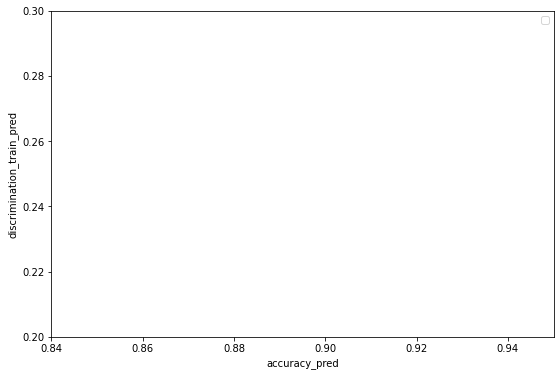

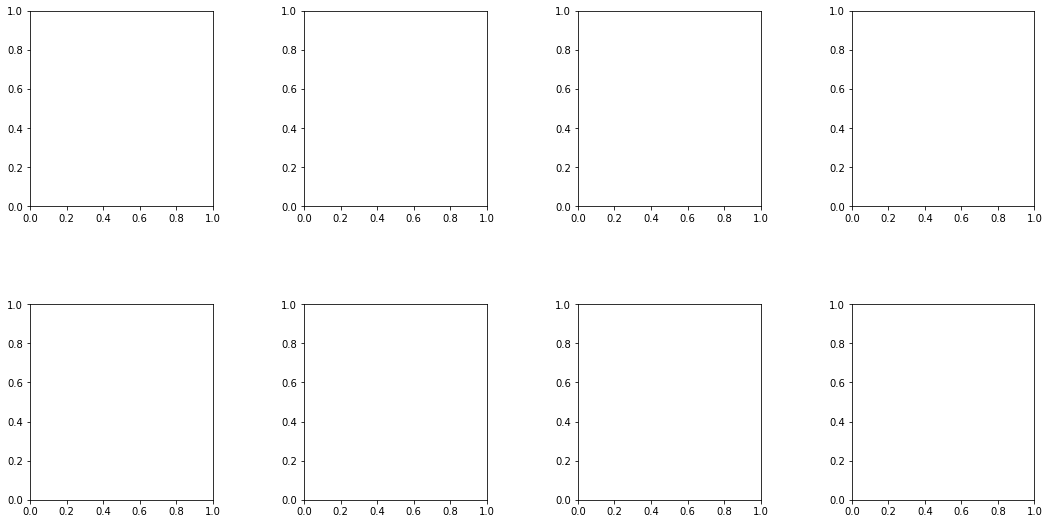

In [9]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_pred", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_pred", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

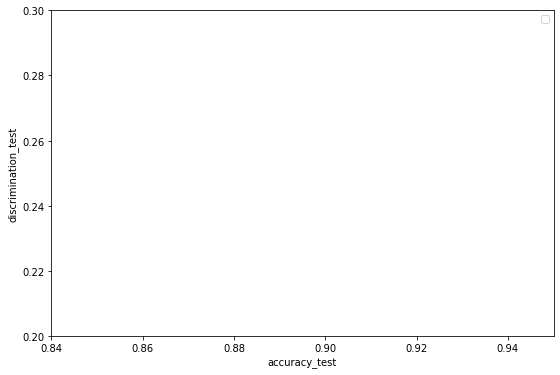

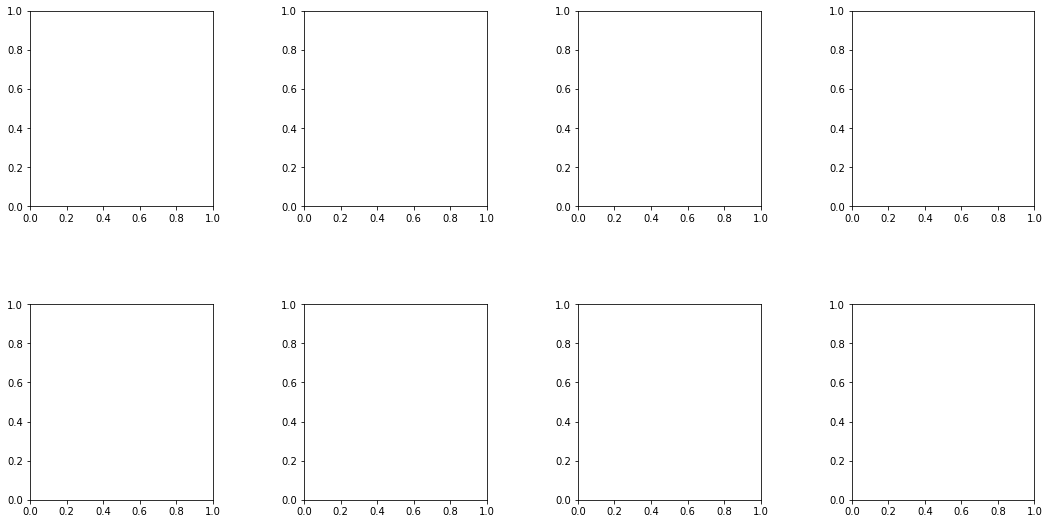

In [10]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

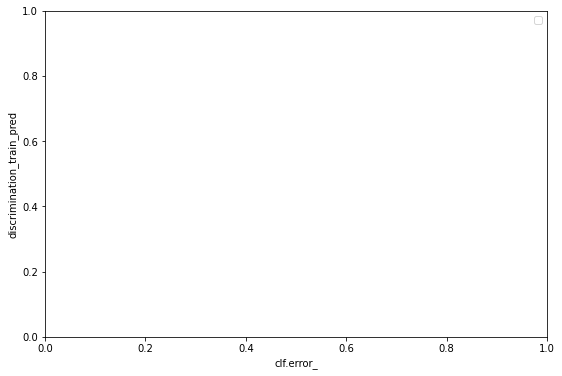

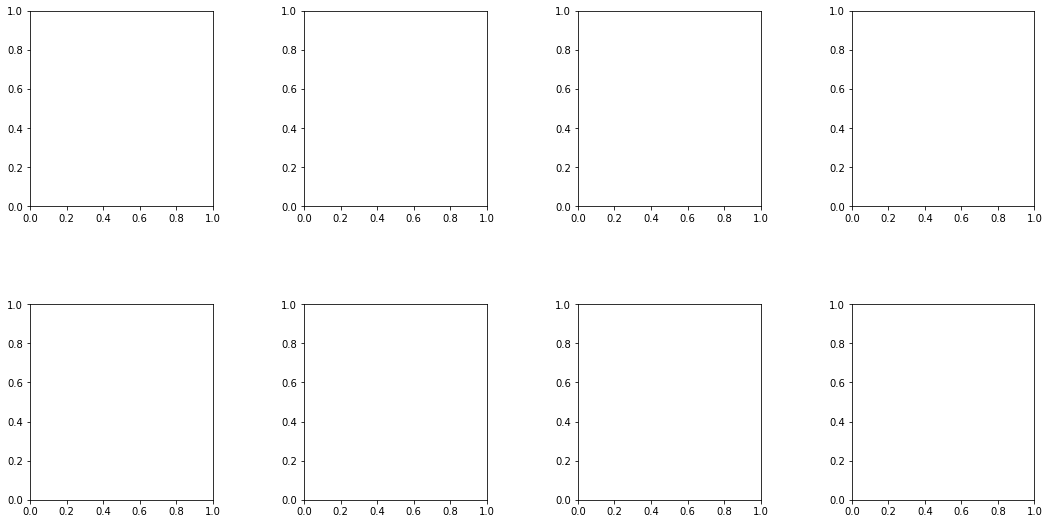

In [11]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

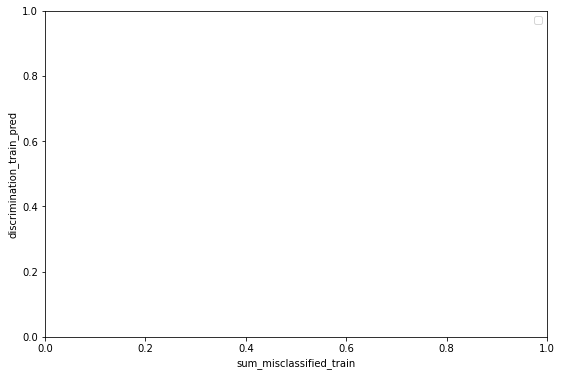

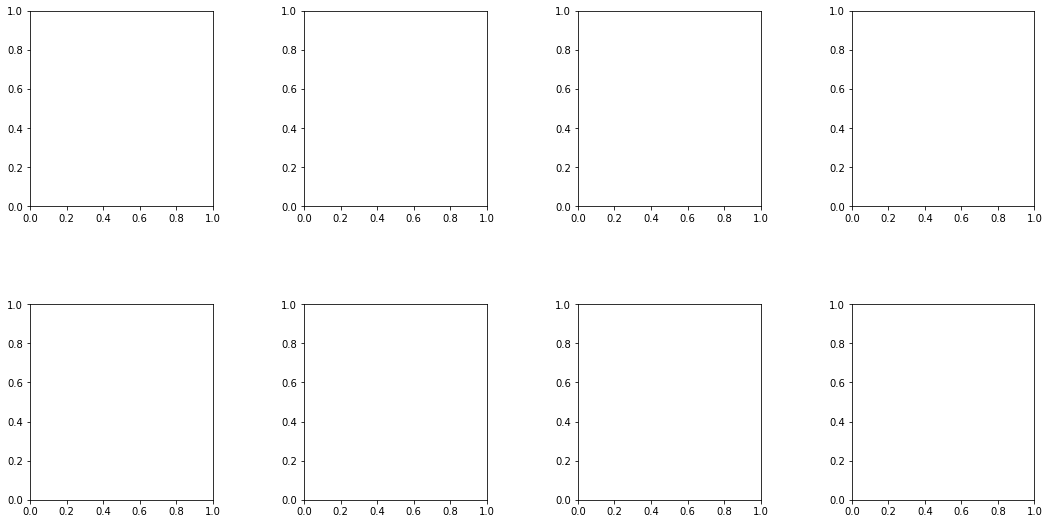

In [12]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

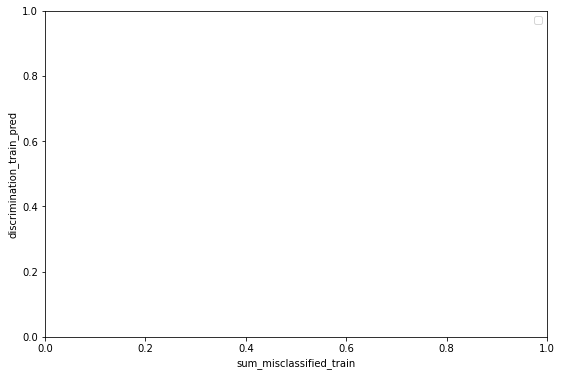

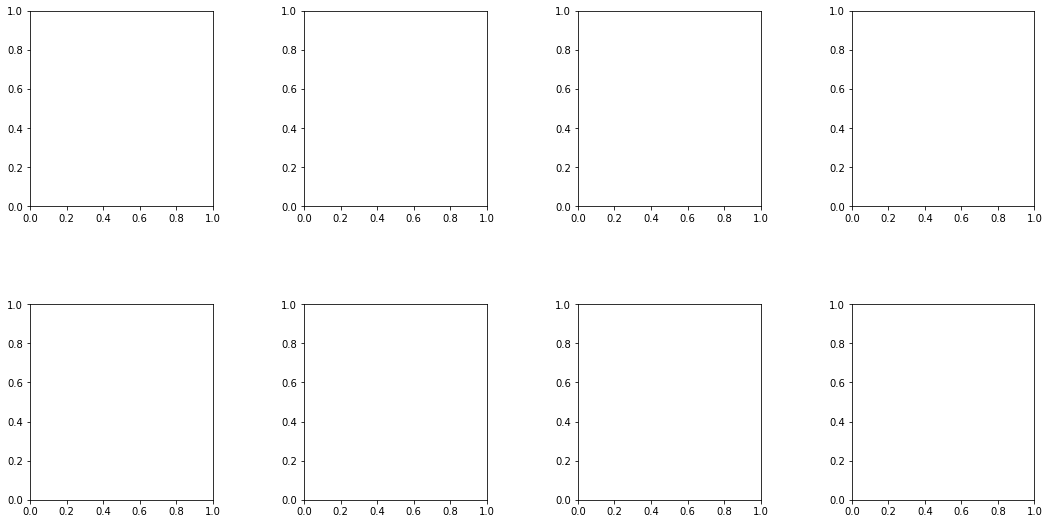

In [13]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

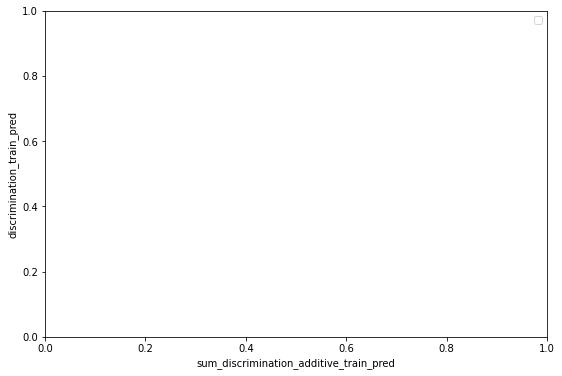

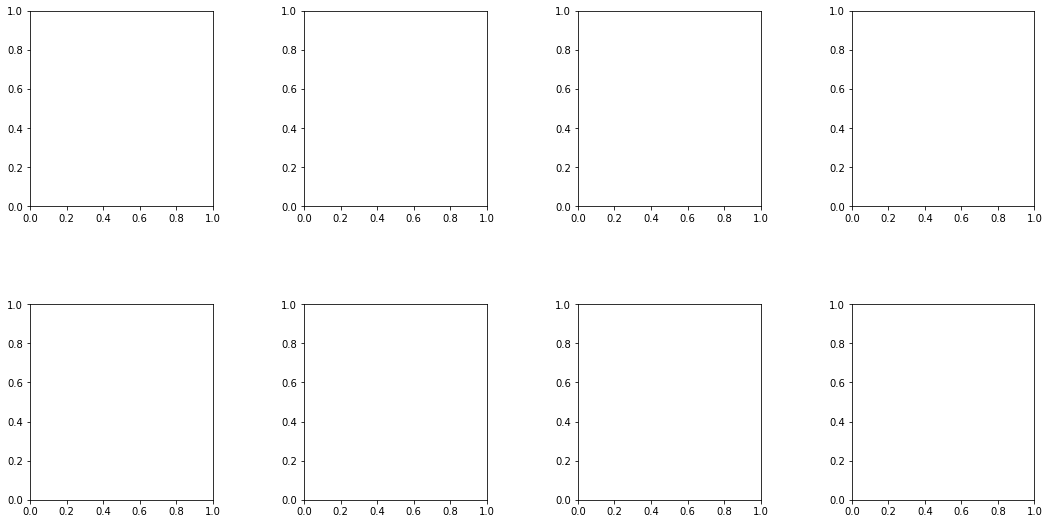

In [14]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

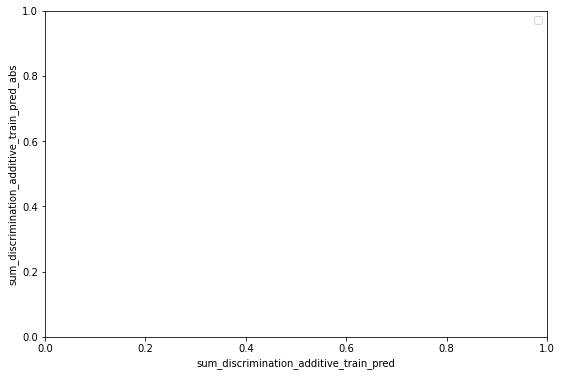

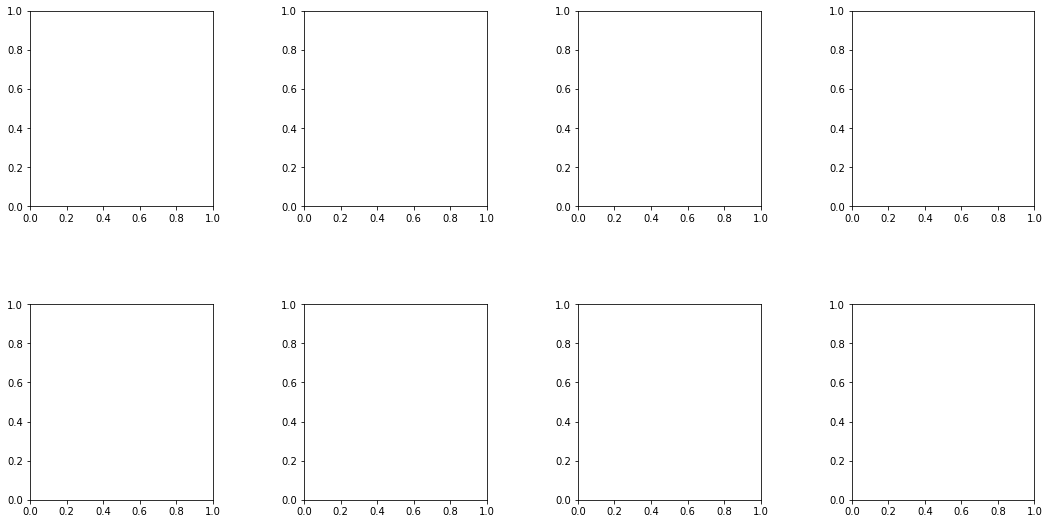

In [15]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)